# Parte A - Exploración de datos

**GITHUB link**: https://github.com/GDistel/NLP_product_reviews

## Cargado de librerias y datos

In [1]:
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import spacy
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [2]:
data_train = pd.read_json('./dataset_amazon/dataset_es_train.json', lines = True)
filas, columnas = data_train.shape

print('Filas: ', filas)
print('Columnas: ', columnas)
data_train.head()

Filas:  200000
Columnas:  8


,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0491108,product_es_0296024,reviewer_es_0999081,1,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,es,electronics
1,es_0869872,product_es_0922286,reviewer_es_0216771,1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,es,electronics
2,es_0811721,product_es_0474543,reviewer_es_0929213,1,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...,es,drugstore
3,es_0359921,product_es_0656090,reviewer_es_0224702,1,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.,es,wireless
4,es_0068940,product_es_0662544,reviewer_es_0224827,1,Llega tarde y co la talla equivocada,Devuelto,es,shoes


## Análisis Exploratorio de Datos básico

### Conteo general de valores faltantes:
#### Cuántos valores faltantes hay por cada columna?

In [3]:
data_train.isna().sum()

review_id           0
product_id          0
reviewer_id         0
stars               0
review_body         0
review_title        0
language            0
product_category    0
dtype: int64

Tenemos un dataset en el que no hay valores faltantes.

### Conteo de estrellas:
#### Pregunta: Qué cantidad de observaciones corresponde a cada posible valor del rating medido en estrellas?

Veamos cómo está balanceado nuestro dataset con respecto a la variable a predecir: las estrellas asignadas al producto.

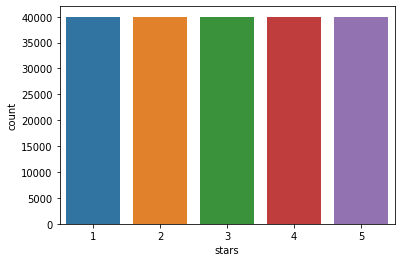

In [4]:
sns.countplot(data_train.stars)
plt.show()

Tenemos un dataset perfectamente balanceado, ya que hay 40000 observaciones por cada cantidad de estrellas dentro del rango posible de estrellas de 1 a 5.

### Conteo de categorías de producto:
#### Pregunta: Cuántas categorías de productos hay?

In [5]:
data_train.product_category.value_counts()

home                        26962
wireless                    25886
toy                         13647
sports                      13189
pc                          11191
home_improvement            10879
electronics                 10385
beauty                       7337
automotive                   7143
kitchen                      6695
apparel                      5737
drugstore                    5513
book                         5264
furniture                    5229
baby_product                 4881
office_product               4771
lawn_and_garden              4237
other                        3937
pet_products                 3713
personal_care_appliances     3573
luggage                      3328
camera                       3029
shoes                        2754
digital_ebook_purchase       1843
video_games                  1733
jewelry                      1598
musical_instruments          1530
watch                        1490
industrial_supplies          1482
grocery       

Aquí observamos que estaremos analizando el rating en estrellas a lo largo de **30 categorías** de productos diferentes. Quizás ésta emerja como una variable importante a la hora de predecir estrellas. Lo veremos más adelante.

### Conteo de productos agrupados por categorías
#### Pregunta: Qué cantidad de productos han sido revisados por cada categoría?

In [6]:
productos_por_categoria = data_train.groupby('product_category')['product_id'].nunique()
print('Total de productos a los que se les ha hecho un review: ', productos_por_categoria.sum())
productos_por_categoria

Total de productos a los que se les ha hecho un review:  150938


product_category
apparel                      4569
automotive                   5438
baby_product                 3701
beauty                       5524
book                         4400
camera                       2296
digital_ebook_purchase       1494
drugstore                    4175
electronics                  7517
furniture                    3845
grocery                       826
home                        20440
home_improvement             8202
industrial_supplies          1146
jewelry                      1247
kitchen                      4820
lawn_and_garden              3051
luggage                      2585
musical_instruments          1137
office_product               3666
other                        3071
pc                           8345
personal_care_appliances     2582
pet_products                 2763
shoes                        2277
sports                      10084
toy                         10361
video_games                  1308
watch                        11

Aquí observamos que las 200000 observaciones del dataset corresponden a 150938 productos. Ésto nos brinda más confianza en la posibilidad de generalizar nuestro modelo en comparación con una situación en la que todas ésas observaciones correspondiesen a unos pocos productos.

In [7]:
# Podemos también observarlo en términos percentuales
data_train.groupby('product_category')['product_id'].nunique() * 100 / data_train.shape[0]

product_category
apparel                      2.2845
automotive                   2.7190
baby_product                 1.8505
beauty                       2.7620
book                         2.2000
camera                       1.1480
digital_ebook_purchase       0.7470
drugstore                    2.0875
electronics                  3.7585
furniture                    1.9225
grocery                      0.4130
home                        10.2200
home_improvement             4.1010
industrial_supplies          0.5730
jewelry                      0.6235
kitchen                      2.4100
lawn_and_garden              1.5255
luggage                      1.2925
musical_instruments          0.5685
office_product               1.8330
other                        1.5355
pc                           4.1725
personal_care_appliances     1.2910
pet_products                 1.3815
shoes                        1.1385
sports                       5.0420
toy                          5.1805
video_games

### Conteo de lenguajes
#### Pregunta: En cuántos lenguajes diferentes fueron escritas las revisiones de los productos?

Estamos utilizando los datos correspondientes a revisiones de producto hechas en castellano. Sin embargo, no está de más asegurarse de ésto.

In [8]:
data_train.language.value_counts()

es    200000
Name: language, dtype: int64

Efectivamente, ésta columna es una constante, por lo que podemos descartarla:

In [9]:
data_train.drop(columns = ['language'], inplace = True)

### Identificador de revisión
#### Pregunta: Hay observaciones repetidas?

Vamos a asegurarnos de que cada identificador de las revisiones es un valor único. Si es así, podemos descartarlo. Es una manera de asegurarnos de que no hay observaciones repetidas. Pero ésta variable, en realidad, no aporta nada. Simplemente hace las veces de índice (como el índice de un pandas dataframe). Probablemente haya sido una "primary key" en la base de datos de Amazón.

In [10]:
data_train.review_id.nunique()

200000

In [11]:
# No hay observaciones repetidas, entonces descartamos la columna
data_train.drop(columns = ['review_id'], inplace = True)

### Revisores únicos
#### Pregunta: Cuántos revisores únicos hay?

In [12]:
data_train.reviewer_id.nunique()

179076

Se observa que hay una gran cantidad de revisores únicos en el total de observaciones.

## Transformación de los datos y EDA avanzado

Vamos a proceder ahora a realizar un EDA pero ya utilizando las librerías específicas de NLP (NLTK y Spacy). Pero primero crearemos una sola columna con el texto entero de la review: `review_title` + `review_body`. Y luego una columna adicional con ese mismo texto pero "lemmatizado".

La primera transformación es de carácter práctico, ya que el algoritmo no diferenciará entre título y cuerpo de la review, sino que andrá a analizar las palabras que uno y otro contienen. La transformación a texto ¨lemmatizado¨ es útil para evitar que el algoritmo tome como palabras diferentes, aquello que en realidad es la misma palabra en diferentes conjugaciones.

De acuerdo a la explicación en la bitácora 39:
> Otra manera de llevar distintas palabras a un raíz común en la que comparten un significado es mediante el procezo de 'Lemmatizar' el texto. Es similar al 'Stemming' pero un poco más educado, ya que intenta realizar el proceso teniendo en cuenta cuál es el rol que la palabra cumple en el texto. Esto quiere decir que su accionar será distinto si la palabra a lemmantizar está actuando como verbo, sustantivo, etc. 


In [13]:
# Instanciamos spaCy
sp = spacy.load('es_core_news_sm')

def lemmatizar(dataset, dataset_name):
    try:
        # Dado que el lemmatizer lleva mucho tiempo, si existen los datos guardados en disco, los cargamos.
        dataset = pd.read_csv(f'./DS_Proyecto_03_{dataset_name}_lemma.csv')
        print('Datos cargados desde el archivo')
    except Exception as e:
        print(e)
        print('Generando lemmatizado...')
        dataset['review_text'] = dataset['review_title'] + '. ' + dataset['review_body']
        dataset['review_lemm'] = '' # la inicializamos con un string vacio
        stop_words = sp.Defaults.stop_words

        for i in range(dataset.shape[0]):
            review = dataset['review_text'].iloc[i]
            review_tk = nltk.RegexpTokenizer('\w+').tokenize(review)
            review_tk_lower_stop = [word.lower() for word in review_tk if word.lower() not in stop_words]
            review_clean = ' '.join(review_tk_lower_stop)
            review_clean = sp(review_clean)
            lemmas_list = [word.lemma_ for word in review_clean]
            dataset['review_lemm'].iloc[i] = ' '.join(lemmas_list)

        dataset.to_csv(f'DS_Proyecto_03_{dataset_name}_lemma.csv', index = False, encoding = 'utf-8')
    
    return dataset

In [14]:
data_train = lemmatizar(data_train, 'data_train')

Datos cargados desde el archivo


Creamos una función que inicialize un objeto (diccionario) que contenga el análisis exploratorio que queremos realizar.
Abordamos, por separado, cada una de los valores posibles de las calificaciones: de 1 a 5.
La estructura propuesta abajo facilita guardar cada uno de los pasos del análisis e información correspondiente
a cada calificación.

In [15]:
def init_eda_nlp():
    eda_nlp = {
        'stars_1': {
            'df': data_train[data_train.stars == 1],
            'all_tokens': None, # Éstos serán relleandos con posterioridad, con un df con la frecuenia de
            'df_review_tk_freq': None # cada token (para 'body', y 'title')
        },
        'stars_2': {
            'df': data_train[data_train.stars == 2],
            'all_tokens': None,
            'df_review_tk_freq': None
        },
        'stars_3': {
            'df': data_train[data_train.stars == 3],
            'all_tokens': None,
            'df_review_tk_freq': None
        },
        'stars_4': {
            'df': data_train[data_train.stars == 4],
            'all_tokens': None,
            'df_review_tk_freq': None
        },
        'stars_5': {
            'df': data_train[data_train.stars == 5],
            'all_tokens': None,
            'df_review_tk_freq': None
        },
    }
    return eda_nlp

In [16]:
def create_token_frequencies(stop_words):
    eda_nlp = init_eda_nlp()
    
    for stars_x in eda_nlp:

        print(f'Looping through {stars_x}...', end = '') # cada una de las calificaciones posibles (1 a 5)
        eda_nlp[stars_x]['all_tokens'] = []

        for i in range(eda_nlp[stars_x]['df'].shape[0]):

            # Creamos una lista de tokens para el texto de la review:
            review = eda_nlp[stars_x]['df'].iloc[i].review_text
            review_tokenized = nltk.RegexpTokenizer('\w+').tokenize(review)
            review_tokenized = [word for word in review_tokenized if word not in stop_words]
            eda_nlp[stars_x]['all_tokens'].append(review_tokenized)
            
        # Convertimos una lista de listas de tokens en una sola lista con todos los tokens (para 'title' y 'body')
        eda_nlp[stars_x]['all_tokens'] = list(itertools.chain(*eda_nlp[stars_x]['all_tokens']))

        # Creamos un df de pandas, para el texto de la review, con la frecuencia de cada token.
        review_tk_freq_list = list(nltk.FreqDist(eda_nlp[stars_x]['all_tokens']).items())
        eda_nlp[stars_x]['df_review_tk_freq'] = pd.DataFrame(review_tk_freq_list, columns = ['Word','Frequency'])

        # Ordenamos de mayor a menor frecuencias los df que acabamos de crear
        eda_nlp[stars_x]['df_review_tk_freq'].sort_values('Frequency', inplace = True, ascending = False)

        # Reseteamos los índices, luego del ordenamiento realizado
        eda_nlp[stars_x]['df_review_tk_freq'].reset_index(drop = True, inplace=True)

        print('finished.\n')
        
    return eda_nlp

In [17]:
def plot_token_frequencies(eda_nlp):
    for stars_x in eda_nlp:
        print(f'Frecuencias para {stars_x}')
        target_df = eda_nlp[stars_x][f'df_review_tk_freq']
        plt.figure(figsize = (15,11))
        plot = sns.barplot(x = target_df.iloc[:30].Frequency, y = target_df.iloc[:30].Word, orient = 'h')
        plt.show()
        print('\n')

Looping through stars_1...finished.

Looping through stars_2...finished.

Looping through stars_3...finished.

Looping through stars_4...finished.

Looping through stars_5...finished.

Frecuencias para stars_1


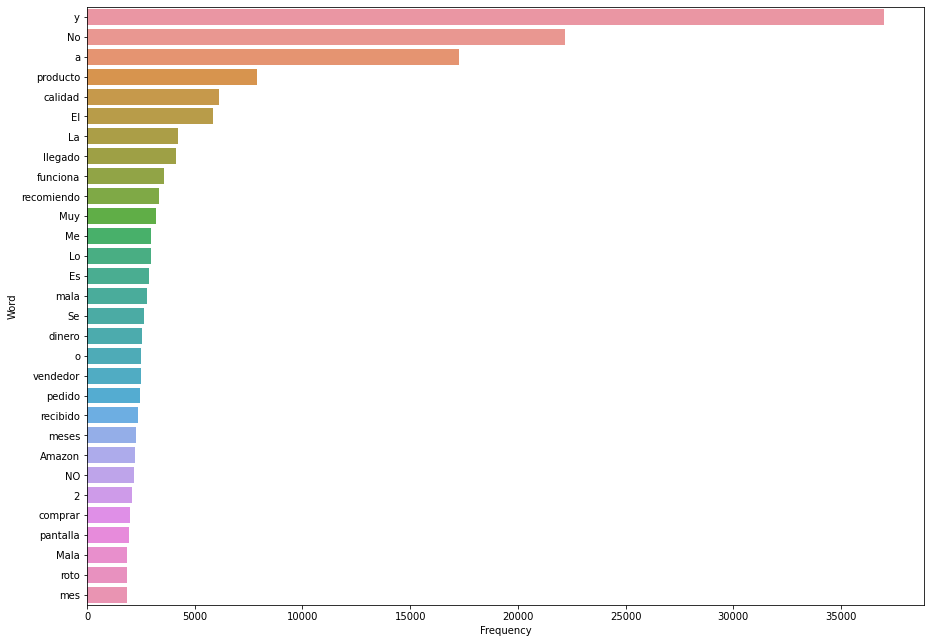



Frecuencias para stars_2


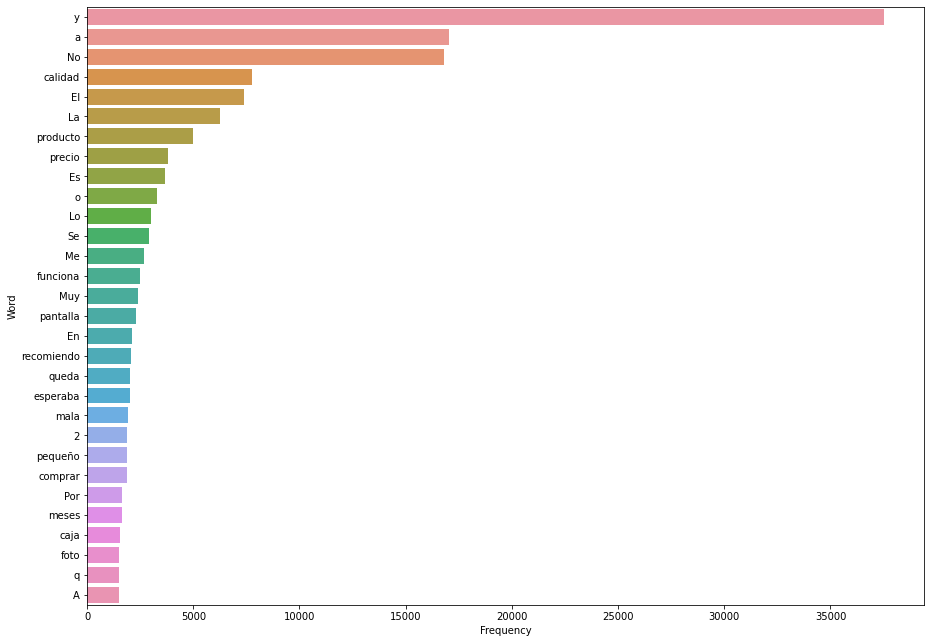



Frecuencias para stars_3


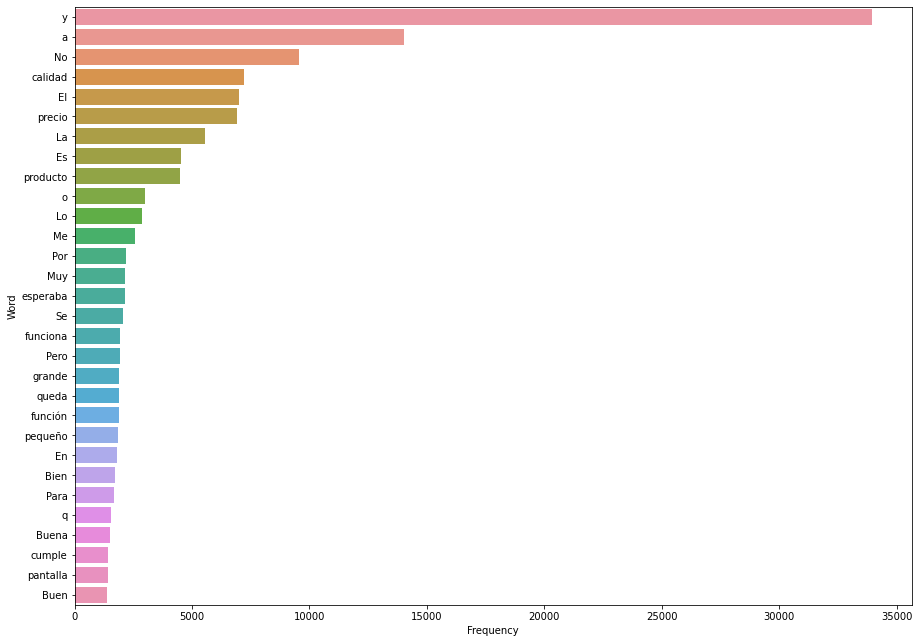



Frecuencias para stars_4


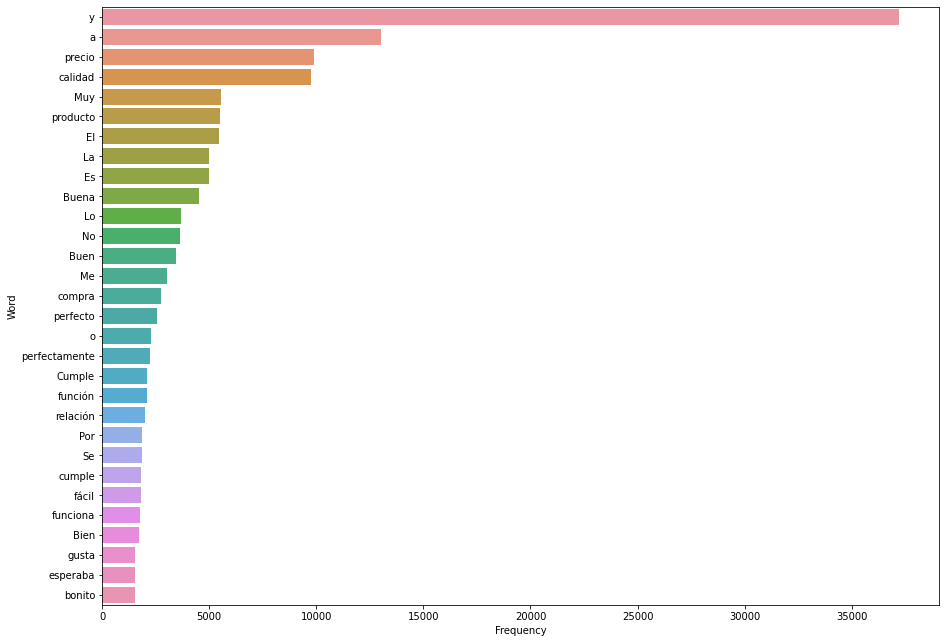



Frecuencias para stars_5


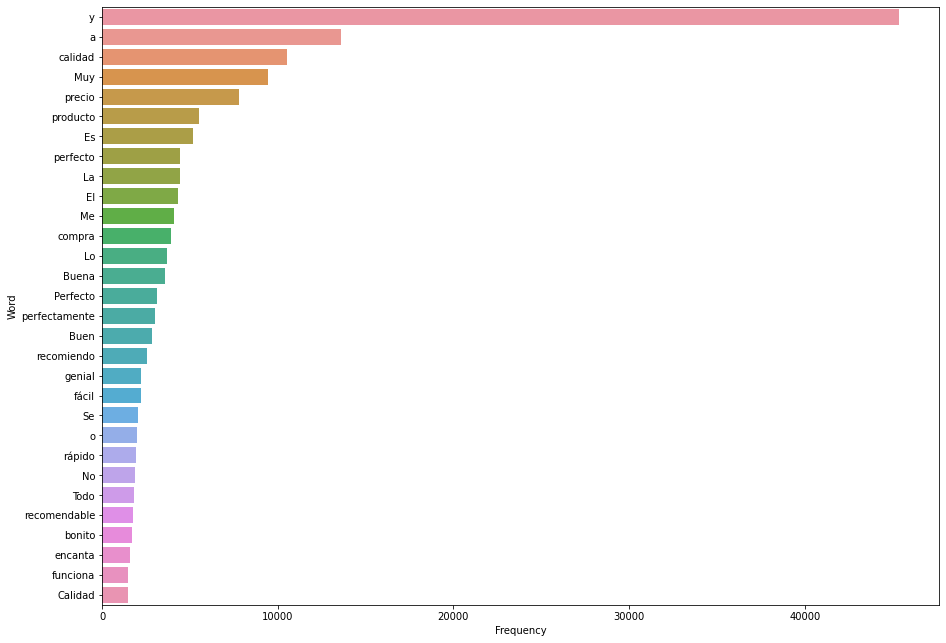

In [18]:
# Ejecutamos la función que acabamos de definir
eda_nlp = create_token_frequencies(sp.Defaults.stop_words)

# Y graficamos, para cada una de las calificaciones, las frecuencias para el 'title' y el 'body'
plot_token_frequencies(eda_nlp)

En ésta primera exploración de las frecuencias observamos que aparecen algunas stopwords que no venían por defecto en Spacy. Entonces vamos a proceder a agregarlas y a correr de nuevo el ploteo de frecuencias.

In [19]:
# Armamos una lista con las nuevas palabras que queremos agregar como stopwords:
nuevas_stopwords = [
    'y', 'muy', 'a', 'se', 'el', 'la', 'lo', 'le', 'les', 'los', 'las', 'una', 'uno', 'me', 'un', 'es',
    'o', 'por', 'q', 'de', 'para', 'en', '1', '2', '3', '4', '5'
]

# y las añadimos a las stopwords de spacy
spacy_stopwords = list(sp.Defaults.stop_words)
stop_words = spacy_stopwords + nuevas_stopwords

Looping through stars_1...finished.

Looping through stars_2...finished.

Looping through stars_3...finished.

Looping through stars_4...finished.

Looping through stars_5...finished.

Frecuencias para stars_1


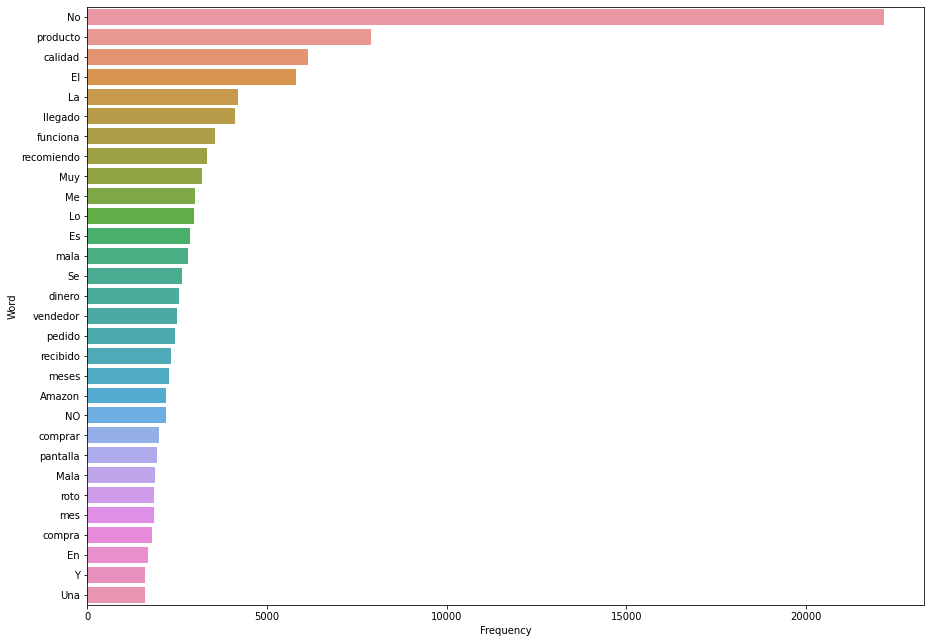



Frecuencias para stars_2


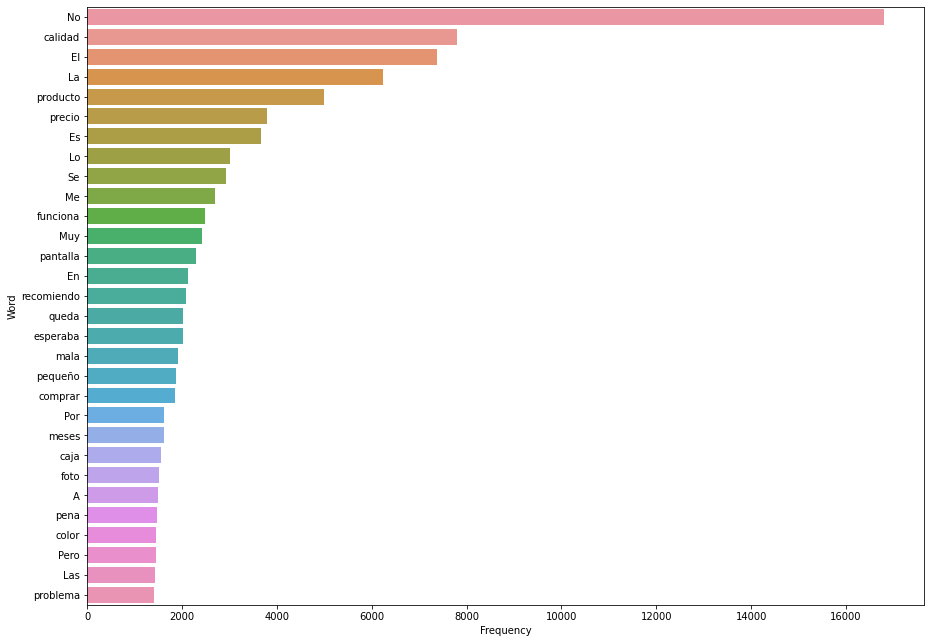



Frecuencias para stars_3


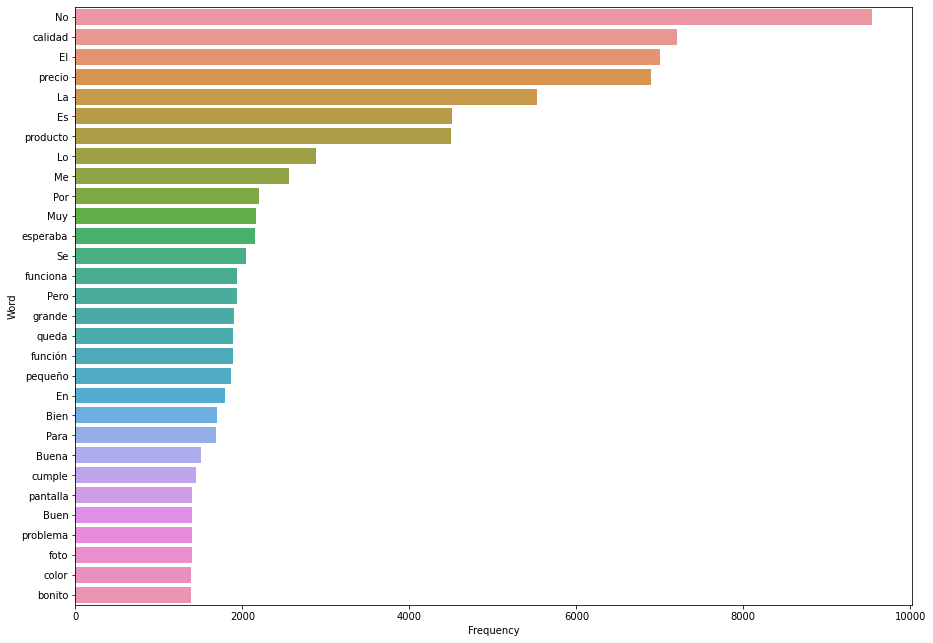



Frecuencias para stars_4


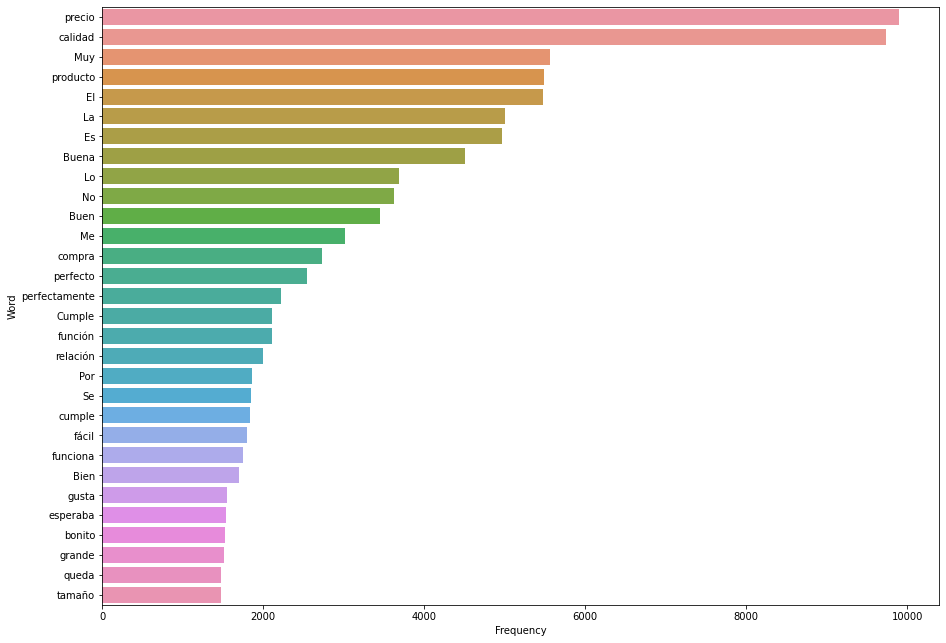



Frecuencias para stars_5


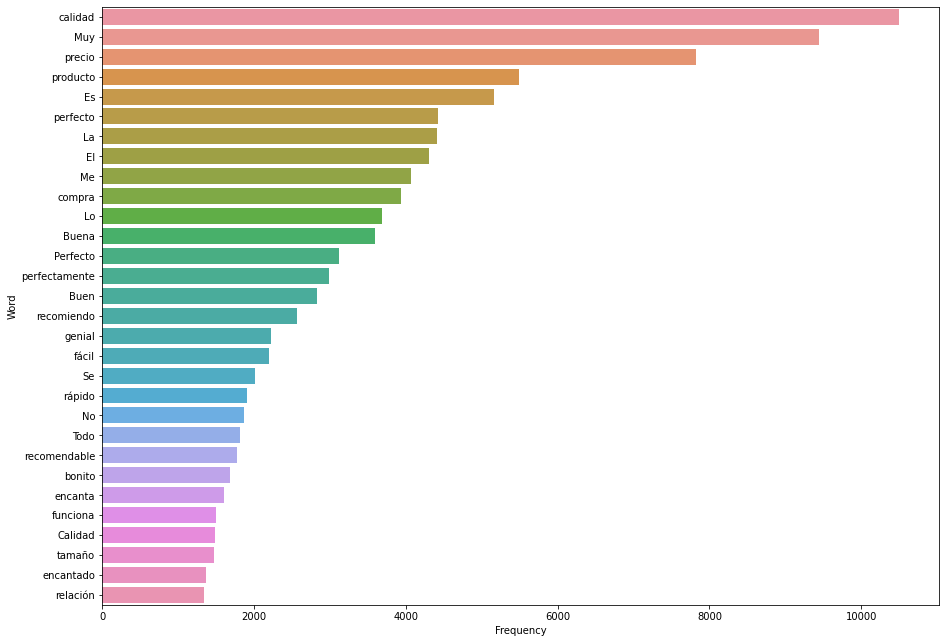

In [20]:
# Y repetimos el ploteo de frecuencias
eda_nlp = create_token_frequencies(stop_words)
plot_token_frequencies(eda_nlp)

Aquí ya podemos observar cómo algunas palabras se asocian más a calificaciones negativas (1 y 2 estrellas) mientras que otras son más frecuentes entre las calificaciones positivas (4 y 5 estrellas). Mencionaremos aquellas que tienen, a partir de nuestro conocimiento de la lengua, una connocatión negativa y positiva respectivamente:

- Negativas: mala/o, fatal, roto, estafa, problema
- Positivas: perfecto/perfectamente, fácil, genial, bonito, ideal, práctico, encanta, gusta/gustado

Sin embargo, también hay otras palabras que aparecen frecuentemente independientemente de la calificación: `calidad`, `producto`, `funciona`, etc. Sin saber el contexto en el que fueron utilizadas, es imposible decir si son negativas o positivas. Por ejémplo, necesitariamos saber si `bueno/a` o `malo/a` se anteponen a `calidad` o a `producto`. O si `no` se antepone a `funciona` ya que, quizás, en realidad sea que `funciona` `perfectamente`).

## TF-IDF

A continuación, prepararemos los datos para ser modelados. Para ésto realizaremos un vectorizado con TF-IDF limitando los features a 1000 y usando hasta 2 ngramas. Y, si bien no sería necesario, pasaremos la matriz obtenida con el vectorizer a un dataframe pandas.
Ésta técnica TF-IDF nos permite asignar un ¨peso¨ a cada término en nuestro texto lemmatizado. Para ser más específico:

>The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general.
>

Traducción propia: *El valor tf-idf incrementa de manera proporcional al número de veces en que una palabra aparece en el document y se compensa por el número de documentos del ¨corpus¨que contengan esa palabra. Ésto ayuda a ajustar por el hecho de que algunas palabras tienden a aparecer de manera más frecuente en general (por particularidades del lenguaje).*

Fuente: https://en.wikipedia.org/wiki/Tf%E2%80%93idf

In [21]:
# Creamos una función que devuelva un df pandas con los vectores
def tfidf_dataset(dataset):
    tfid_vctzer = TfidfVectorizer(max_features = 1000, ngram_range=(1,2))
    sparse_out = tfid_vctzer.fit_transform(dataset['review_lemm'].values.astype('U'))
    X = pd.DataFrame(data = sparse_out.toarray(), columns = tfid_vctzer.get_feature_names())
    return X

In [22]:
X = tfidf_dataset(data_train)
X.to_csv(f'X.csv', index = False, encoding = 'utf-8') # we will utilize this in the next notebook
print(f'Train X contains {X.shape[0]} rows and {X.shape[1]} columns')

Train X contains 200000 rows and 1000 columns


Ésto nos resulta en un dataframe pandas en el que hay una columna por cada una de las palabras que constituyen un feature. Por cada caso, está indicado el peso de la palabra (si es que aparece en el texto lemmatizado).

# Parte B - Modelo de Machine Learning

Estamos frente a un problema de clasificación y no de regresión. Si bien hay veces en que sobre éste tipo de ¨ratings¨ se hacen operaciones como la media, ésto es incorrecto ya que el tipo de variable es ordinal y no cuantitativa. Tomando un determinado texto, queremos predecir en cuál de las 5 categorías caería esa ¨review¨.

La métrica de evaluación elegida es el accuracy (la fracción de las predicciones correctas por sobre el total de predicciones). Ésta métrica suele ser problemática cuando hay clases desbalanceadas. Afortunadamente no es el caso de nuestro dataset, en el cuál cada uno de los posibles valores de la variable a predecir (la cantidad de estrellas) corresponde a la quinta parte de las observaciones. En otras palabras, nuestros datos están perfectamente balanceados.

## Modelo benchmark (LinearSVC sin optimizar)

In [23]:
# X ya lo tenemos de la sección anterior
y = data_train.stars
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [44]:
# Instanciamos el clasificador
clf = LinearSVC(random_state = 42)
# Entrenamos
clf.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
          verbose=0)

In [45]:
y_test_pred = clf.predict(X_test)
accuracy_score(y_test_pred, y_test)

0.480025

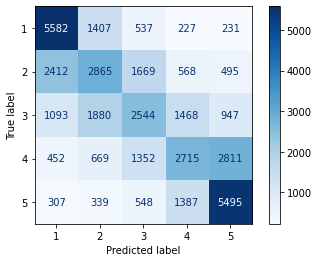

In [46]:
plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues, values_format = '.0f')

El resultado obtenido no parace ser muy bueno o, al menos, esperábamos un poco más. Cabe mencionar que las categorías 1 y 5 se predicen mejor que la 2, 3 y 4.

A continuación, otros dos modelos que consideramos brevemente:

In [27]:
nb = MultinomialNB()
nb.fit(X_train, y_train)

y_test_pred = nb.predict(X_test)
acc_nb = accuracy_score(y_test_pred, y_test)
print(f'Accuracy para NB: {acc_nb}')

Accuracy para NB: 0.4735


In [28]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

y_test_pred = rf.predict(X_test)
acc_rf = accuracy_score(y_test_pred, y_test)
print(f'Accuracy para NB: {acc_rf}')

Accuracy para NB: 0.4535


Los resultados del Accuracy para éstos otros dos modelos son muy similares a lo que encontramos para el LinearSVC.

Además de ser el que mejor accuracy nos brindó, nos decidimos por el LinearSVC por sus mayores velocidades de procesamiento en comparación con otros modelos (e.g. XGBoost, Multinomial NB, Logistic Regression, Random Forest) y porque tiende a tener buena performance en grandes datasets.

Procedamos a optimizarlo.

## Optimización de hiperparámetros del LinearSVC

Vamos a optimizar los siguientes parámetros:
- **penalty**: es la norma de penalización utilizada, cuyos posibles valores son 'l1' y 'l2'. El estándard, para las máquinas de soporte vectorial, es ésta última. Sin embargo nos puede resultar beneficioso explorar el 'l1' ya que tenemos un gran número de features.
- **loss**: es la función de costo, que puede variar entre sus dos opciones 'hinge' y 'squared_hinge' (por defecto). Ésta última penalizaría al modelo más severamente, cuanto más gravemente se equivoque.
- **tol**: el nivel de tolerancia que indica cuándo el algorítmo debe dejar de buscar. En otras palabras, deja de buscar cuando está lo suficientemente cerca de una solución. Vamos a probar, con algunos valores en torno al por defecto de 0.0001.
- **C**: es el parámetro de regularización para éste algoritmo. Según la documentación, la fuerza de la regularización es inversamente proporcional al valor de C, y debe ser un número positivo. Un C menor, hace que la superficie de desición sea más simple, reduce la bondad de la clasificación pero evita el sobreajuste. Y también en sentido contrario: una superficie de desición más compleja, incrementa la bondad de la clasificación para el dataset pero tiende al sobreajuste. Vamos a probar, con algunos valores en torno al valor por defecto de 1.0.
- **multi_class**: los posibles valores 'ovr' y 'crammer_singer' determinan dos estrategias diferentes para problemas de clasificación multiclase, como el que estamos tratando. El primero realiza un "one vs rest", en el que compara cada una de las clases con el resto (en contraposición a estrategias "one vs one", que se pueden utilizar en otras algoritmos de máquinas vectoriales distintas del LinearSVC). El "one vs rest" crea un clasificador por clase. El segundo, Crammer & Singer, crea un sólo clasificador. Sin embargo, como dice en la documentación: *While crammer_singer is interesting from a theoretical perspective as it is consistent, it is seldom used in practice as it rarely leads to better accuracy and is more expensive to compute*. Así que optaremos por no utilizarlo, y nos quedaremos con el 'ovr'.

In [29]:
%%time
param_grid = {
    'penalty': ['l1', 'l2'],
    'loss': ['hinge', 'squared_hinge'],
    'tol': [1e-3, 1e-4, 1e-5],
    'C': [0.01, 0.1, 0.5, 1.0, 1.1],
    'multi_class': ['ovr']
}

clf = LinearSVC(random_state = 42, dual = False) # dual = False es preferible cuando n_samples > n_features
clf_opt = GridSearchCV(estimator = clf, param_grid = param_grid, cv = 5, n_jobs = -1, scoring = 'accuracy')

clf_opt.fit(X_train, y_train)
clf_opt.best_params_

CPU times: user 13.6 s, sys: 10.5 s, total: 24.1 s
Wall time: 43min 5s


{'C': 0.1,
 'loss': 'squared_hinge',
 'multi_class': 'ovr',
 'penalty': 'l1',
 'tol': 0.001}

In [30]:
y_test_pred = clf_opt.predict(X_test)
acc_clf_opt = accuracy_score(y_test_pred, y_test)
print(f'Accuracy para LinearSVC optimizado: {acc_clf_opt}')

Accuracy para LinearSVC optimizado: 0.47805


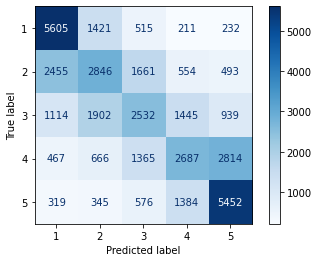

In [32]:
plot_confusion_matrix(clf_opt, X_test, y_test, cmap = plt.cm.Blues, values_format = '.0f')

## Análisis de los resultados obtenidos

Como se observa, no hemos logrado una optimización en comparación con el benchmark. Obtuvimos prácticamente el mismo accuracy, de hecho un poquito menor. Exceptuando el parámetro de penalty `l1` y la tolerancia de `0.001`, los otros dos parámetros optimizados resultaron ser los mismos valores que vienen por defecto.

De todas formas, a continuación exponemos cuál es la información que estaría utilizando el modelo (el ¨best estimator¨ obtenido con el GridSearchCV) para predecir.

Es importante notar que la propiedad `.coef_` arroja una matriz de 5x1000. Ésto es así ya que la estrategia ¨one vs rest¨ (ovr), utilizada para entrenar el modelo, crea 5 clasificadores. Cada uno de ellos corresponde a cada una de los valores posibles que puede adoptar la variable objetivo (cada una de las estrellas).
En otras palabras, cada uno de los clasificadores obtenidos tendrá coeficientes distintos para las features (las 1000 palabras obtenidas mediante TF-IDF para cada una de las estrellas).

In [33]:
# Matriz de coeficientes. Cada fila corresponde a uno de los clasificadores creados por la estrategia ¨ovr¨
coef_matrix = clf_opt.best_estimator_.coef_
coef_matrix.shape

(5, 1000)

In [34]:
def create_features_coef_df(coefs):
    features = list(X.columns) # the name of the features (of the lemmatized terms)
    coefs_list = list(coefs)
    tuples_list = list(zip(features, coefs))
    df = pd.DataFrame(tuples_list, columns = ['Feature', 'Coef'])
    df_sorted = df.sort_values(by = 'Coef', ascending = False) # from highest coef to lowest coef
    df_sorted.reset_index(drop = True, inplace = True)
    return df_sorted

Vamos a explorar las 30 palabras que tienen el coeficiente más alto para cada clasificador

In [35]:
one_star_clf = create_features_coef_df(coef_matrix[0,:])
one_star_clf.head(30)

,Feature,Coef
0,estafar,2.554871
1,timar,1.840148
2,malísimo,1.733832
3,basura,1.627133
4,desastre,1.571939
5,fatal,1.556311
6,engañar,1.511021
7,vergüenza,1.349392
8,horrible,1.333726
9,recibir,1.213650


In [36]:
two_star_clf = create_features_coef_df(coef_matrix[1,:])
two_star_clf.head(30)

,Feature,Coef
0,penar,0.855521
1,convencer,0.828143
2,decepcionante,0.755502
3,pobre,0.721611
4,bajo,0.713969
5,decepcionar,0.699205
6,deficiente,0.672963
7,regular,0.619801
8,incómodo,0.595065
9,dejar desear,0.558216


In [37]:
three_star_clf = create_features_coef_df(coef_matrix[2,:])
three_star_clf.head(30)

,Feature,Coef
0,mejorable,1.008612
1,aceptable,0.929342
2,regular,0.879541
3,medio,0.803760
4,normal,0.627521
5,apañar,0.604061
6,justo,0.556680
7,preciar pedir,0.550349
8,restar,0.491753
9,demas,0.473612


In [38]:
four_star_clf = create_features_coef_df(coef_matrix[3,:])
four_star_clf.head(30)

,Feature,Coef
0,único,1.502881
1,unico,1.070702
2,poner estrellar,0.999306
3,único pegar,0.769778
4,dar estrellar,0.752179
5,cumplir,0.643406
6,ponerle,0.642933
7,correcto,0.619939
8,relación,0.615563
9,llegar perfecto,0.576784


In [39]:
five_star_clf = create_features_coef_df(coef_matrix[4,:])
five_star_clf.head(30)

,Feature,Coef
0,perfecto,1.790901
1,encantar,1.727333
2,excelente,1.630191
3,fantástico,1.522510
4,genial,1.432947
5,espectacular,1.331883
6,precioso,1.278964
7,perfección,1.211985
8,perfectamente,1.199731
9,maravillar,1.187299


Como se observa, los términos que adquirieron mayor peso (coeficientes más altos) por cada clasificador, son congruentes con la categoría.

Para ser más específicos:

- **1 estrella**: `estafar`, `timar`, `malísimo`, `basura`, `desastre`, `fatal`, `engañar`, etc. Son todas palabras que en la lengua castellana tienen una clara connotación negativa. Se comunica principalmente que al usuario se le ha sacado el dinero y absolutamente no le dieron lo que esperaba.

- **2 estrellas**: `penar`, `convencer`, `decepcionante`, `bajo`, `pobre`, `deficiente`, `dejar desear`, `incómodo`, etc. Son también palabras que tienen connotación negativa, si bien podemos estar de acuerdo en que tienen una ¨tonalidad¨ menor de negatividad en comparación con las de 1 estrella. El producto ha quedado muy lejos de las expectativas.

- **3 estrellas**: `mejorable`, `aceptable`, `normal`, `regular`, `medio`. Todas ellas son neutrales.

- **4 estrellas**: `único`, `poner estrellar` / `dar estrellar`, `cumplir`, `correcto`. Ésta categoría parece ser bastante ambigua, para ser honestos. Hay palabras que tienen una ligera connotación positiva como `cumplir` y `correcto`. Pero otras, hipotetizamos, estarían apuntando a explicar porque le pusieron 4 estrellas en vez de 5. La palabra `único` quizás, en el contexto de la review, estaría apuntando a explicar una sóla cosa que le haya faltado al producto para no merecer la máxima evaluación. La palabra `relación` también aparece en lo que quizás sería una típica expresión en éste tipo de contexto: `relación calidad precio`.

- **5 estrellas**: `perfecto`, `encantar`, `excelente`, `fantástico`, `genial`. Todas tienen una connotación claramente positiva, y comunican mucho más que mera conformidad con el producto.

Todo ésto coincide con lo que habríamos esperado. Los clasificadores para cada categoría utilizan palabras que tienen, en general, gran nivel de congruencia con las evaluaciones correspondientes. Éstamos convencidos de que cualquier hablante de la lengua castellana estaría de acuerdo con ésta conclusión.

# Parte C - Investigación

Como sugiere la consigna, y considerando los accuracies obtenidos, parece que, en efecto, valdría la pena intentar convertir éste problema de clasificación multiclase en un problema binario.

Podríamos dividirlo de ésta manera:
- Estrellas **1**, **2** y **3** serían calificación negativa, que codeamos como **0**
- Estrellas **4** y **5** serían calificación positiva, que codeamos como **1**

La decisión de dejar la categoría de 3 estrellas como una calificación negativa en el problema binario, corresponde a una interpretación desde la lógica del business. En términos coloquiales, una evaluación positiva nos deja tranquilos y contentos, mientras que una evaluación negativa nos empujaría a mejorar. Por eso, le damos más peso a la parte negativa e invitaríamos así, a los vendedores de los productos, a apuntar a la excelencia.

Se espera que el desempeño mejore al binificar, ya que estaríamos simplificando el problema. Pasaríamos de 5 categorías a solamente 2. De ésta manera, se espera que muchos de los desaciertos del modelo en el problema de 5 estrellas, quedarían capturados correctamente en el problema de calificación binaria.

El accuracy debería estar por encima de 0.5, ya que ese es el márgen de una decisión azarosa cuando se tienen dos categorías posibles. Idealmente se lograría un accuracy por encima de 0.75.

Es de particular importancia notar que, si decidimos ir por la senda del problema binario, quedaríamos con un dataset ligeramente desbalanceado (recordemos que nuestros datos, hasta éste momento estaban perfectamente balanceados). En el problema binario, el 60% de los datos corresponderían a la clasificación negativa, mientras que el 40% restante a la clasificación positiva. 

A continuación podemos hacer algunas pruebas preliminares para ver si estamos orientados correctamente.

In [40]:
# Convertimos el dataframe a binario

binify = lambda x: 1 if x > 3 else 0
y_train_bin = y_train.transform(binify)
y_test_bin = y_test.transform(binify)
y_train_bin.value_counts()

0    96075
1    63925
Name: stars, dtype: int64

In [41]:
y_test_bin.value_counts()

0    23925
1    16075
Name: stars, dtype: int64

In [42]:
clf_binary = LinearSVC(random_state = 42)
clf_binary.fit(X_train, y_train_bin)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
          verbose=0)

In [43]:
y_test_pred_bin = clf_binary.predict(X_test)
accuracy_score(y_test_pred_bin, y_test_bin)

0.815425

Como supusimos, el accuracy aumenta cuando el problema se simplifica a dos categorías. Ésto indicaría que binificar el problema nos pondría en una buena dirección para avanzar con la tarea.